In [2]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

In [3]:
import cv2 as cv
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

from diffusers import DPMSolverMultistepScheduler, DiffusionPipeline
import torch

from generation.inpainting.inpainter import InpaintingGenerator

This notebook is a simple implementation of the inpainting process of a original size high quality mammograms.

# Creating healthy metadata

We first need a listo fo all the healthy mammograms.

In [12]:
# from utils import dataset_CDD_CESM, patient_CDD

# mode = 'substracted'
# dataset_CESM = dataset_CDD_CESM(mode=mode)
# print(dataset_CESM)

# # find normal cases
# normal_cases_meta = dataset_CESM.metadata[dataset_CESM.metadata['Tags']=='normal'].reset_index(drop=True)
# # save 
# normal_cases_meta.to_csv(repo_path / 'data/CDD-CESM/metadata' / 'normal_cases.csv', index=False)

# Generation idea
Check visually the normal cases, and their closeups

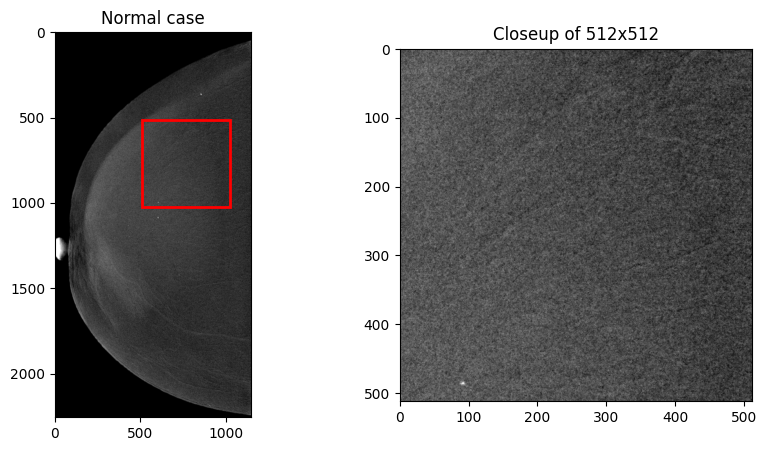

In [5]:
# data
im_dir = repo_path / 'data/CDD-CESM/images/substracted'
normal_cases_meta = pd.read_csv(repo_path / 'data/CDD-CESM/metadata' / 'normal_cases.csv')

# row_example
row = normal_cases_meta.iloc[2]

# load the image
im_path = im_dir / (row['Image_name'] + '.jpg')
im_path = im_path.with_name(im_path.name.replace(' ', '')) # rmeove space if necessary
im = cv.imread(str(im_path), cv.IMREAD_GRAYSCALE)

# closeup
x1, y1, x2, y2 = 512, 512, 1024, 1024

# show image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(im, cmap='gray')
axs[0].set_title('Normal case')
# closup of 512x512
im_closup = im[y1:y2, x1:x2]
axs[1].imshow(im_closup, cmap='gray')
axs[1].set_title('Closeup of 512x512')
# show bbox of closeup in original image
axs[0].add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='r', lw=2))

plt.show()

im_closup = np.repeat(im_closup[:,:,None], 3, axis=2)

In [4]:
def compute_area_stas():

    training_mask_path = repo_path  /'data/CDD-CESM/metadata/bboxes/split_1/train_set.csv'
    train_set = pd.read_csv(training_mask_path)

    mask_areas = []
    for bbox in train_set['bbox']:
        bbox = eval(bbox)
        if bbox[2] < 512 and bbox[3] < 512: # excluding large cases
            # compute mask area
            mask_areas.append(bbox[2]*bbox[3])


    # get 25th and 75th percentiles
    q25, q75 = np.percentile(mask_areas, 25), np.percentile(mask_areas, 75)

    return q25, q75

def compute_ratios():
    
    training_mask_path = repo_path  /'data/CDD-CESM/metadata/bboxes/split_1/train_set.csv'
    train_set = pd.read_csv(training_mask_path)

    mask_ratios = []
    for bbox in train_set['bbox']:
        bbox = eval(bbox)
        if bbox[2] < 512 and bbox[3] < 512:
            # compute mask area
            mask_ratios.append(bbox[3]/bbox[2])
    
    # compute mean and std
    mean, std = np.mean(mask_ratios), np.std(mask_ratios)

    return mean, std

def create_lesion_bbox(im_xrange, im_yrange, area_range, ratio_range):
    while True:
        # sample x and y
        x1 = np.random.randint(im_xrange[0], im_xrange[1])
        y1 = np.random.randint(im_yrange[0], im_yrange[1])
        # sample area and ratio
        area = np.random.randint(area_range[0], area_range[1])
        ratio = np.random.uniform(ratio_range[0], ratio_range[1])

        # compute width and height
        width = int(np.sqrt(area*ratio))
        height = int(np.sqrt(area/ratio))

        # compute other corners
        x2 = x1 + width
        y2 = y1 + height

        # if all corners are inside the mask
        if x2 < im_xrange[1] and y2 < im_yrange[1]:
            # create mask of the bbox
            bbox_mask = np.zeros((im_xrange[1], im_yrange[1]), dtype=np.uint8)
            bbox_mask[y1:y2,x1:x2] = 255

            break
    
    return bbox_mask, (x1, y1, x2, y2)

25th percentile: 19832.0, 75th percentile: 98427.0
ratio mean: 1.0027800839513035, ratio std: 0.4185633550698671


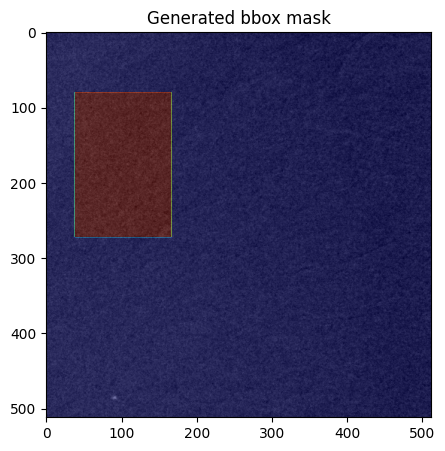

In [5]:
# compute area stats
q25, q75 = compute_area_stas()
print(f'25th percentile: {q25}, 75th percentile: {q75}')
mean, std = compute_ratios()
print(f'ratio mean: {mean}, ratio std: {std}')
# define ranges
area_range = (q25, q75)
ratio_range = (mean - std, mean + std)
im_xrange = (0, 512)
im_yrange = (0, 512)

# create bbox
bbox_mask, bbox = create_lesion_bbox(im_xrange, im_yrange, area_range, ratio_range)

plt.figure(figsize=(5,5))
plt.imshow(im_closup, cmap='gray')
plt.title('Generated bbox mask')
plt.imshow(bbox_mask, cmap='jet', alpha=0.4)
plt.show()

## Inpaiting process

In [25]:
# define model and load weights
model_dir=repo_path / 'generation/inpainting/results/CEM-small_mass_split-1'
# model_dir = 'runwayml/stable-diffusion-inpainting'
pipe = DiffusionPipeline.from_pretrained(
    model_dir,
    safety_checker=None,
    torch_dtype=torch.float16
).to("cuda")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/ricardo/miniconda3/envs/diffusion_class/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [25]:
# Set diffusion pipeline
im_RGB = Image.fromarray(im_closup)
prompt = "a mammogram with a lesion"
negative_prompt = ""
num_samples = 1

 # HP
diffusion_steps = 50
guidance_scale = 1

with torch.autocast("cuda"), torch.inference_mode():
    synth = pipe(
        prompt=prompt,
        image=im_RGB,
        mask_image=bbox_mask, # mask coming from the sketchpad
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=diffusion_steps,
        guidance_scale=guidance_scale,
        height=512,
        width=512,
        generator=None,
    ).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

## Inpaint this patch back into the original image

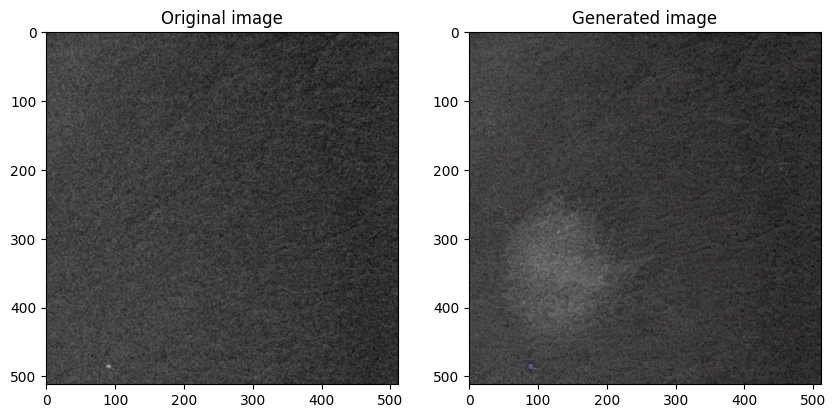

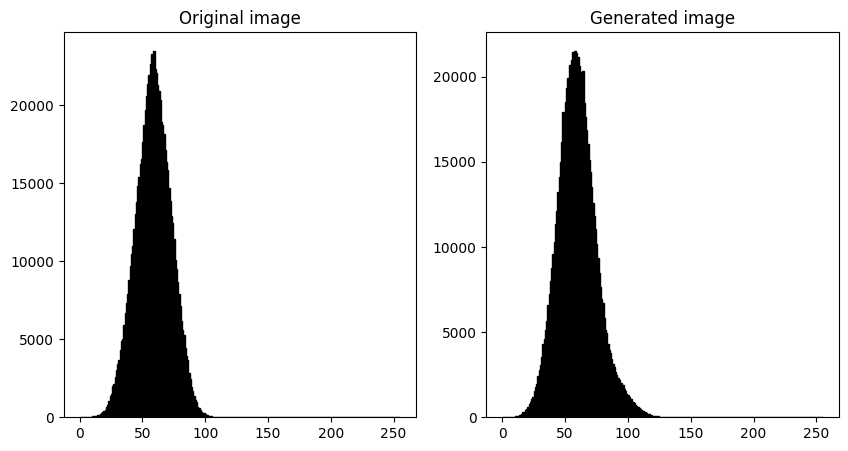

In [26]:
synth_array = np.asarray(synth)

# show orignal image histogram
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(im_closup, cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(synth_array, cmap='gray')
axs[1].set_title('Generated image')
plt.show()
# show histogram
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(im_closup.ravel(), bins=256, range=(0, 255), fc='k', ec='k')
axs[0].set_title('Original image')
axs[1].hist(synth_array.ravel(), bins=256, range=(0, 255), fc='k', ec='k')
axs[1].set_title('Generated image')
plt.show()

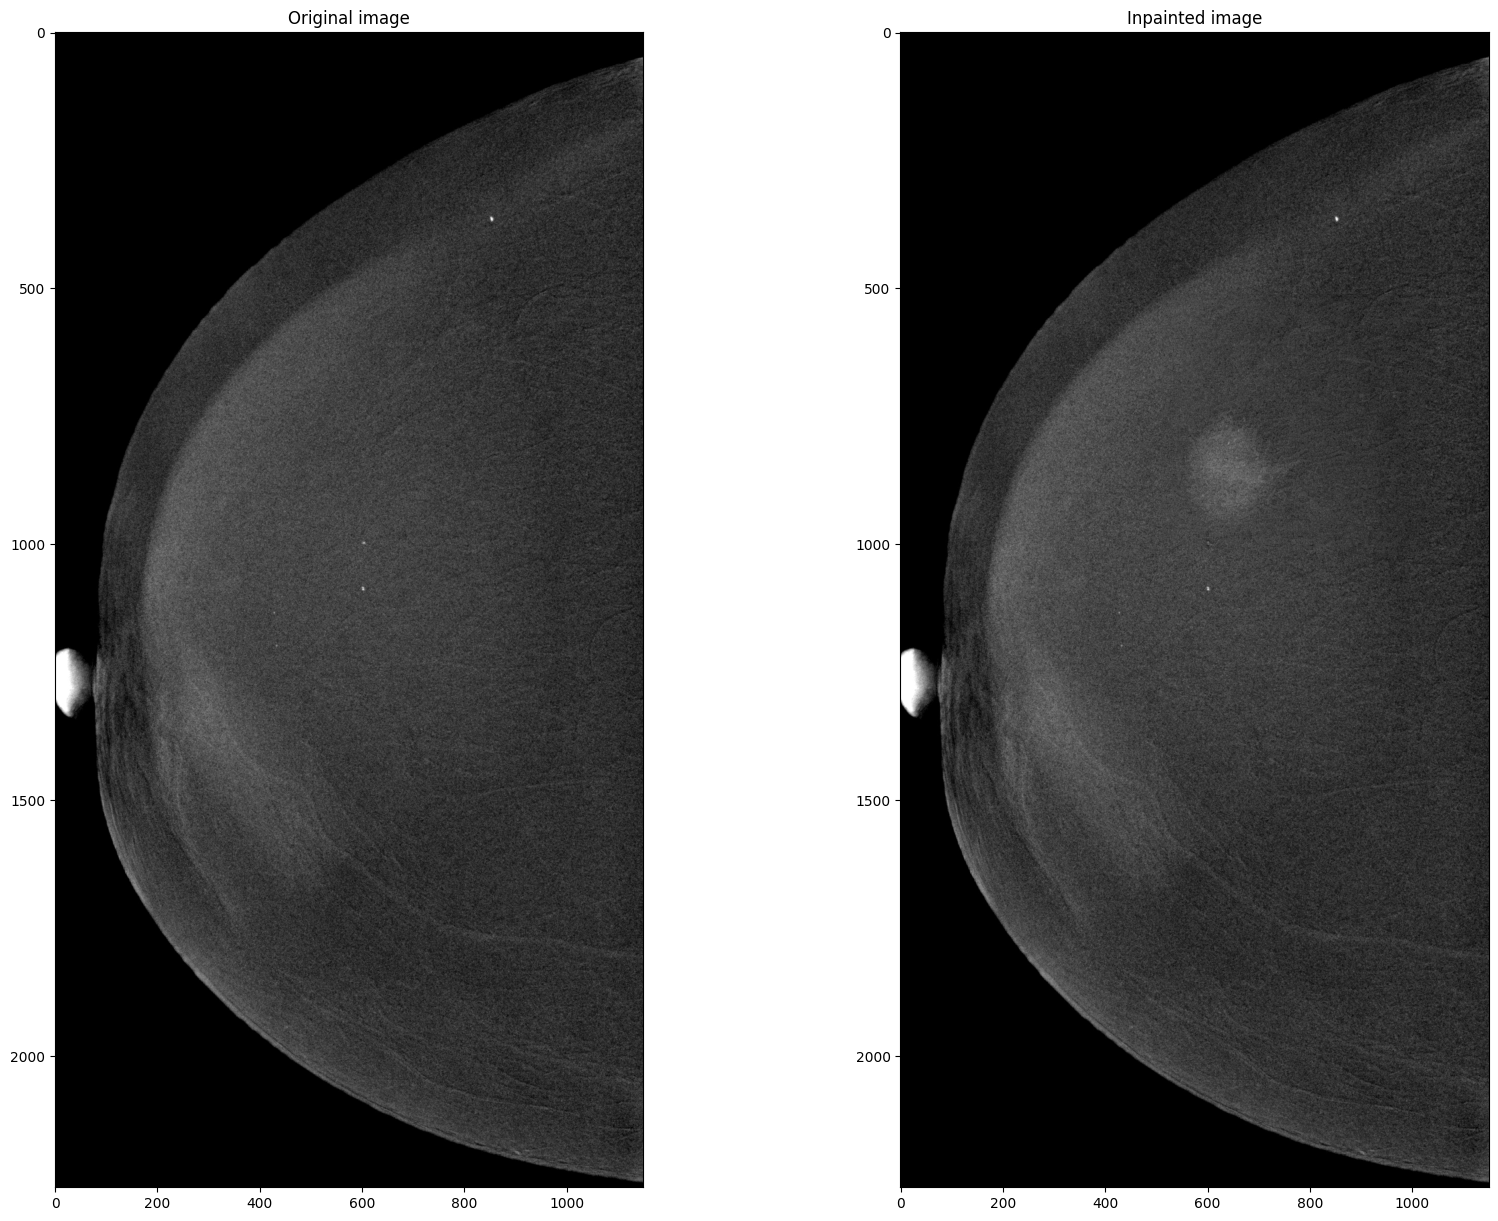

In [27]:
# reinstert in the orignal image
inpainted_im = im.copy()
inpainted_im[y1:y2, x1:x2] = synth_array[:,:,0]
# show orignal and inpainted image
fig, axs = plt.subplots(1, 2, figsize=(20, 15))
axs[0].imshow(im, cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(inpainted_im, cmap='gray')
axs[1].set_title('Inpainted image')
plt.show()

# Clean generation

Now we redo the pipeline but with completely randomize selection of regions

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/ricardo/miniconda3/envs/dreambooth/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


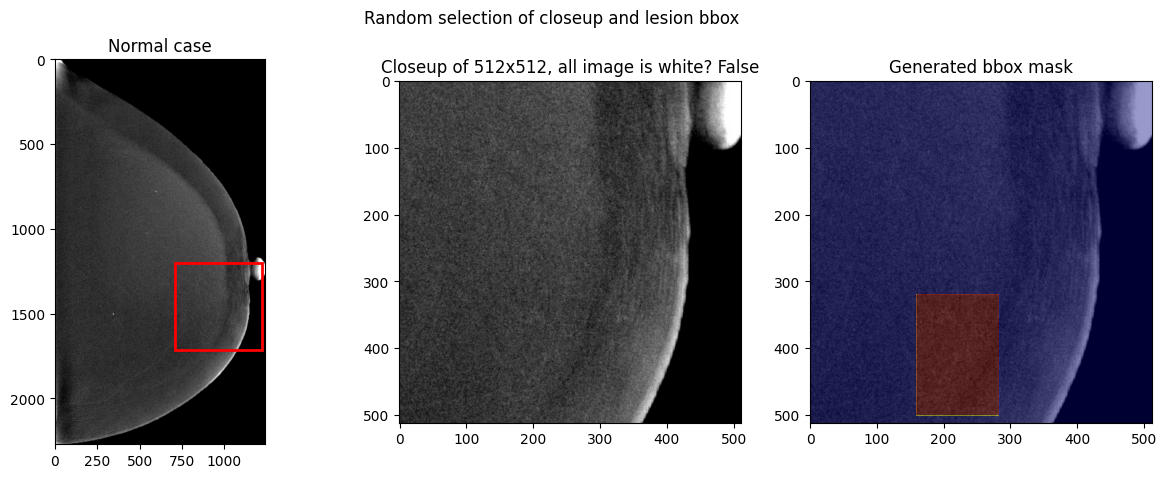

  0%|          | 0/24 [00:00<?, ?it/s]

In [6]:
inpainter = InpaintingGenerator(saving_dir= repo_path / 'generation/inpainting/data/trial')
inpainter.set_generator()
inpainter.start_metadata()

# defining an example
for i, inpainter.current_row in inpainter.metadata[4:5].iterrows():
    inpainter.select_lesion_patch_and_bbox()
    inpainter.show_current_patch_and_bbox()
    inpainter.synthesize_lesion(diffusion_steps=24, guidance_scale=2, seed=0)
    inpainter.save_synthetic_inpainting()
    inpainter.save_metadata()

# save metadata
inpainter.df_synthetic.to_csv(inpainter.saving_dir / 'metadata.csv', index=False)


How many images should be created?
- For the original trianing set, we can create double the number of images


In [36]:
training_metadata = pd.read_csv(repo_path / 'data/CDD-CESM/metadata/bboxes/split_1/train_set.csv')
print(f'The original split of trianing has {training_metadata.shape[0]} cases')

The original split of trianing has 415 cases


Some inpaiting patches have a gray value shift after the inpainting process, even though in theory the whole image must remain the same.
- Idea: compare the region outside the lesion box and force a match between distributions

# Fixing area size
- Originally, the lesion size was reduced to qth25 and qth75. This has given and increase in the performance for the medium size lesions but not the large ones, which are the most important ones.

In [3]:
training_mask_path = repo_path  /'data/CDD-CESM/metadata/bboxes/split_1/train_set.csv'
train_set = pd.read_csv(training_mask_path)

mask_areas = []
mask_ratios = []
for bbox in train_set['bbox']:
    bbox = eval(bbox)
    if bbox[2] < 512 and bbox[3] < 512: # excluding large cases
        # compute mask area
        mask_areas.append(bbox[2]*bbox[3])
        mask_ratios.append(bbox[3]/bbox[2])


# get area 25th and 75th percentiles and ratio mean and std
q25, q75 = np.percentile(mask_areas, 25), np.percentile(mask_areas, 75)
mean_area, std_area = np.mean(mask_areas), np.std(mask_areas)
mean, std = np.mean(mask_ratios), np.std(mask_ratios)

area_range = (q25, q75)
ratio_range = (mean - std, mean + std)

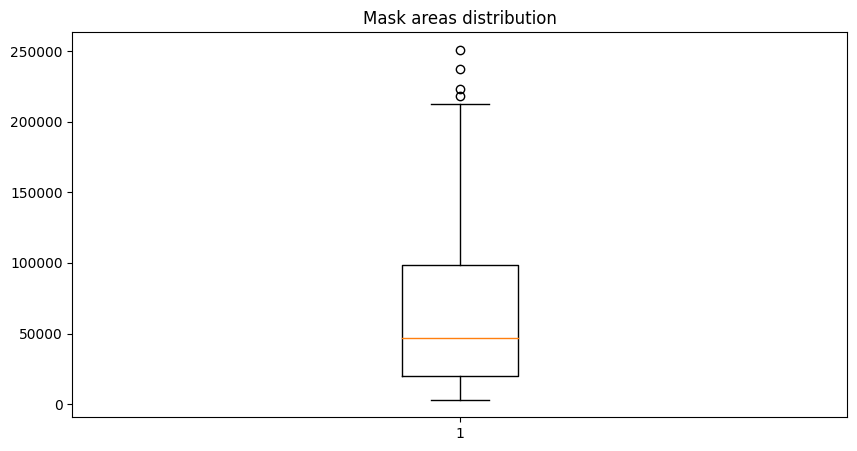

In [12]:
#plot possible ares as boxplot
plt.figure(figsize=(10,5))
plt.boxplot(mask_areas)
plt.title('Mask areas distribution')
plt.show()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/ricardo/miniconda3/envs/dreambooth/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


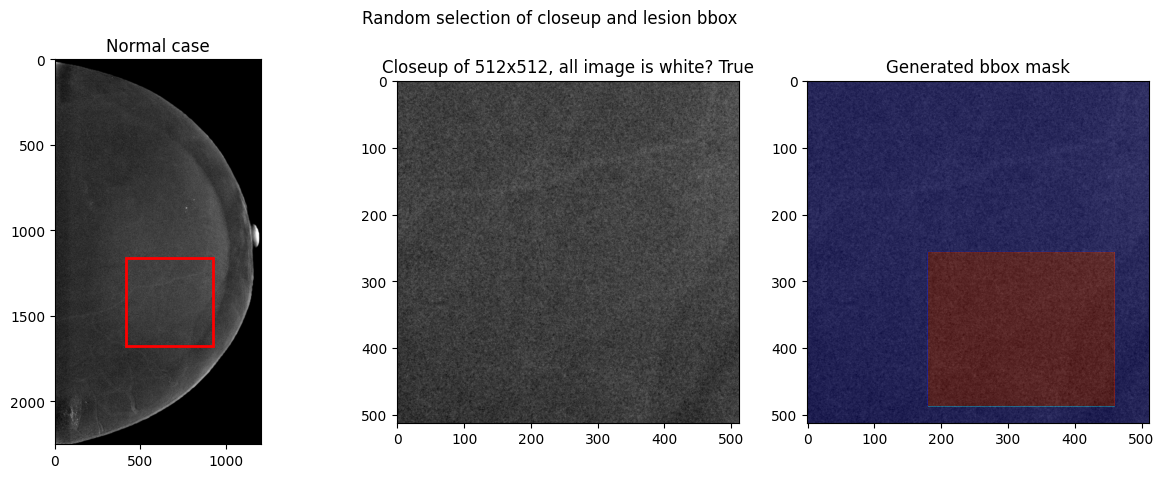

  0%|          | 0/50 [00:00<?, ?it/s]

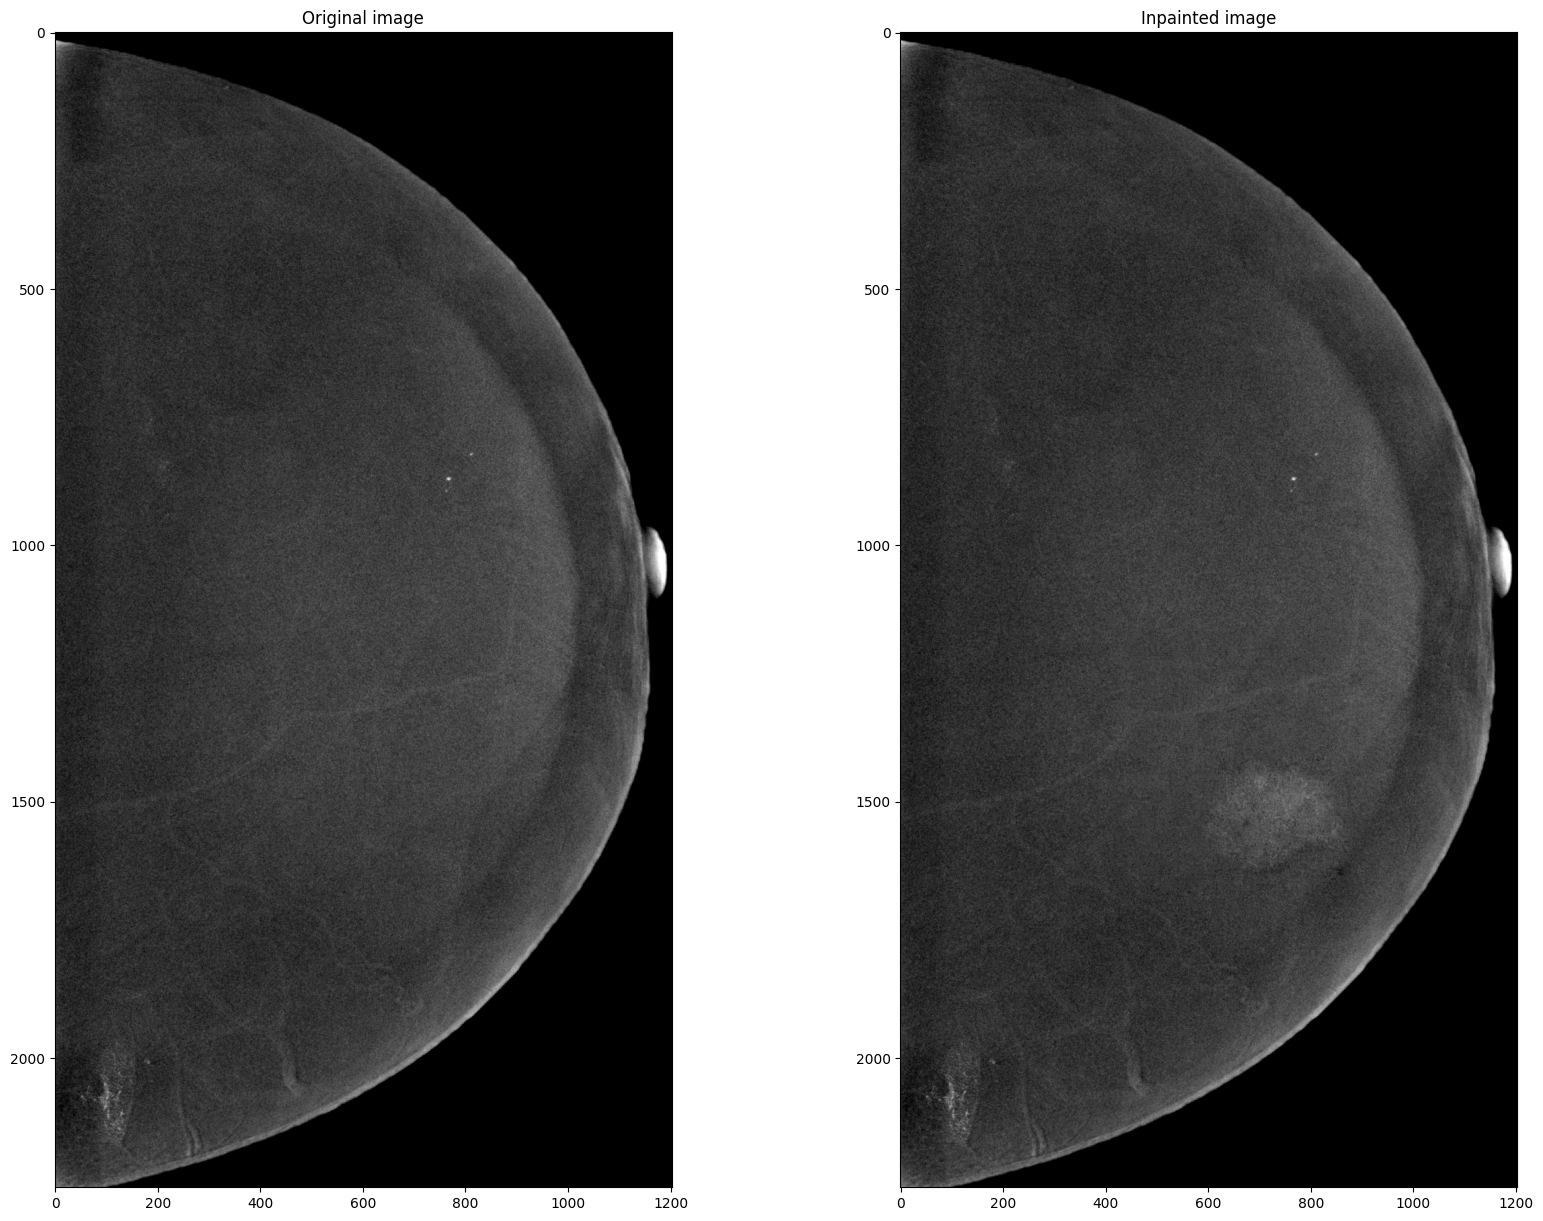

In [10]:
inpainter = InpaintingGenerator(saving_dir= repo_path / 'generation/inpainting/data/trial')
inpainter.set_generator()

# defining an example
patient_metadata = inpainter.metadata[inpainter.metadata['Patient_ID']==54]
inpainter.current_row = patient_metadata.iloc[0]
inpainter.select_lesion_patch_and_bbox()
inpainter.show_current_patch_and_bbox()
inpainter.synthesize_lesion(diffusion_steps=50, guidance_scale=2, seed=0)
inpainter.show_synthetic_inpainting(figsize=(20, 15), histogram=False)

# Fixing inpainting gray shift

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/ricardo/miniconda3/envs/dreambooth/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

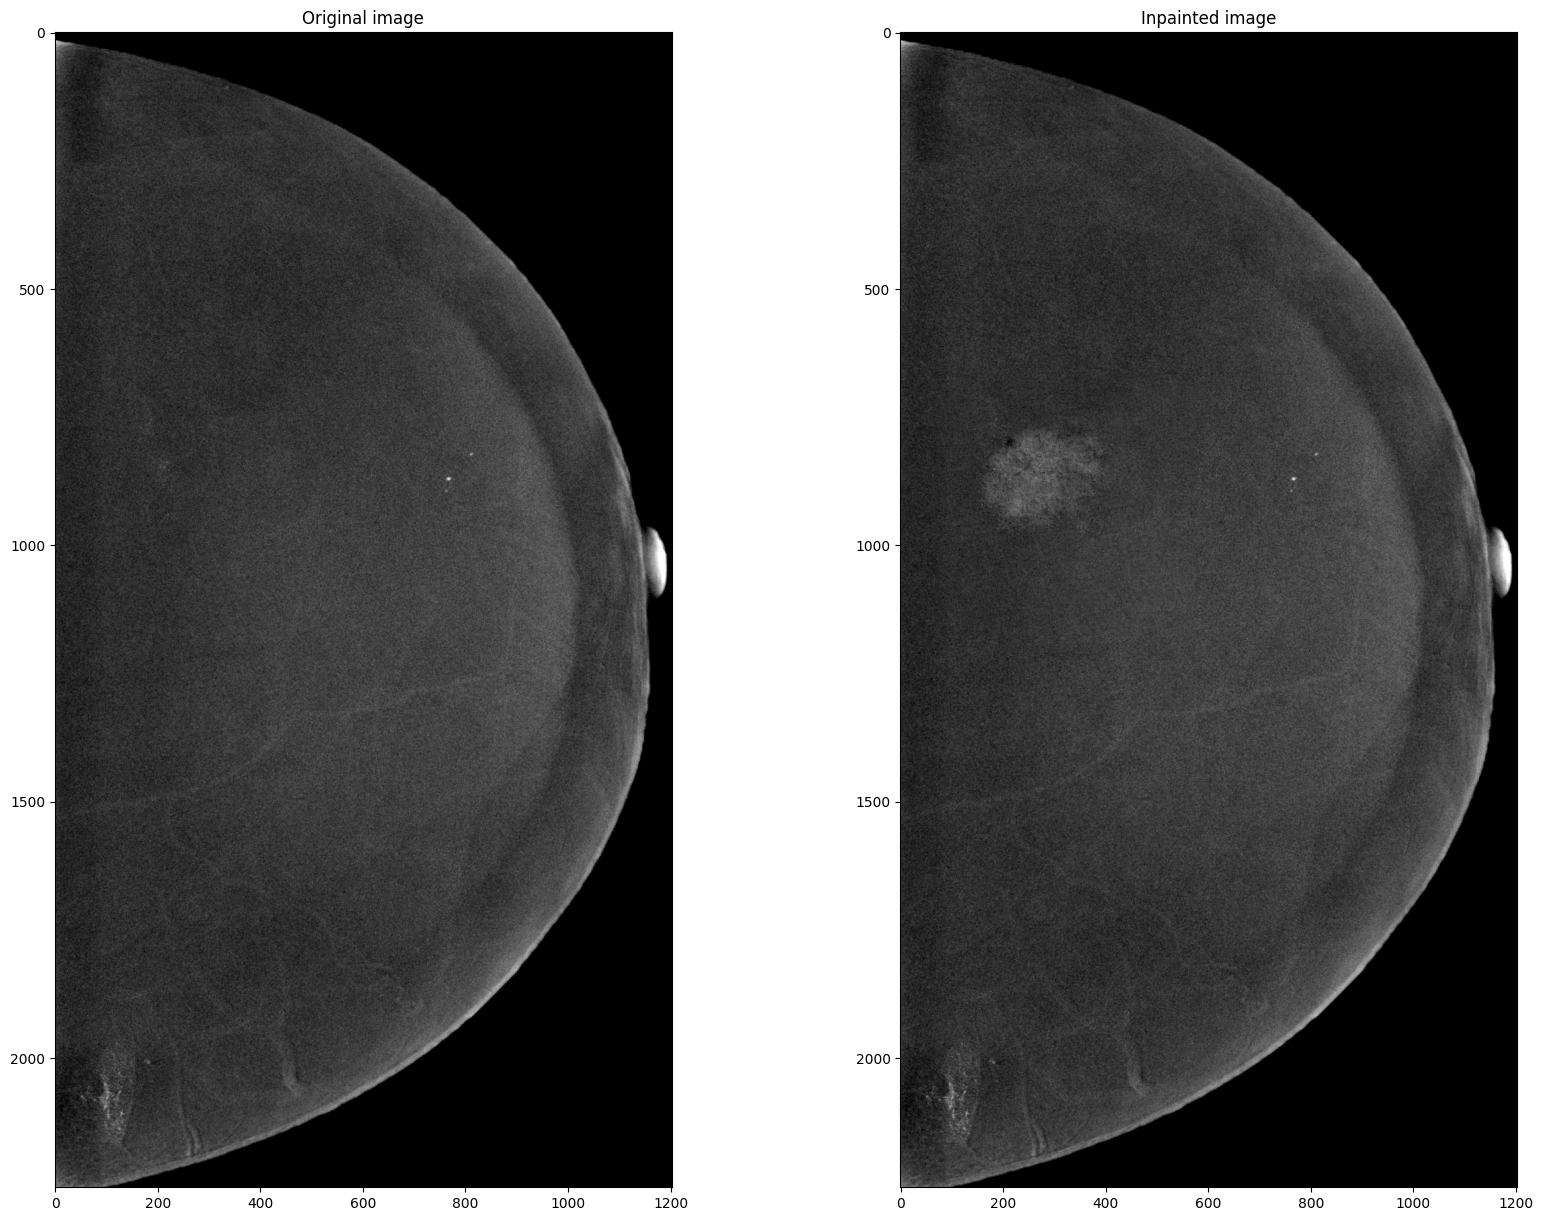

In [4]:
inpainter = InpaintingGenerator(saving_dir= repo_path / 'generation/inpainting/data/trial')
inpainter.set_generator()

# defining an example
patient_metadata = inpainter.metadata[inpainter.metadata['Patient_ID']==54]
inpainter.current_row = patient_metadata.iloc[0]
inpainter.select_lesion_patch_and_bbox()
inpainter.show_current_patch_and_bbox()
inpainter.synthesize_lesion(diffusion_steps=50, guidance_scale=2, seed=0)
inpainter.show_synthetic_inpainting(figsize=(20, 15), histogram=False)

In [43]:
def median_fix(inpainter):
    # compare patch gray values and original patch values
    original_patch = inpainter.current_image[
        inpainter.current_closeup_coords[1]:inpainter.current_closeup_coords[3],
        inpainter.current_closeup_coords[0]:inpainter.current_closeup_coords[2]
    ]
    channel_num = 0
    synthetic_patch = inpainter.current_closup_lesion[:,:,channel_num]

    # create masks
    breast_mask = original_patch!=0 # all pixels in the foreground
    lesion_mask = np.zeros_like(original_patch)
    lesion_mask[inpainter.current_bbox[1]:inpainter.current_bbox[3], inpainter.current_bbox[0]:inpainter.current_bbox[2]] = 1
    lesion_mask = lesion_mask!=1
    statistical_mask = breast_mask & lesion_mask # intesrection of the masks
    # get difference of pixels between the original patch and the synthetic patch using pixels only inside the statistical mask, with isgn
    diff = original_patch.astype(np.float32) - synthetic_patch.astype(np.float32)
    # extract as one dimentional array only the pixels inside the statistical mask
    diff = diff[statistical_mask]
    # compute median
    median_corr = np.median(diff)
    # shift the synthetic patch to match the original patch using the median
    synthetic_patch_shifted = synthetic_patch + median_corr

    new_full_image = inpainter.current_image.copy()
    new_full_image[
        inpainter.current_closeup_coords[1]:inpainter.current_closeup_coords[3],
        inpainter.current_closeup_coords[0]:inpainter.current_closeup_coords[2]] = synthetic_patch_shifted

    return new_full_image

Text(0.5, 1.0, 'Synthetic patch')

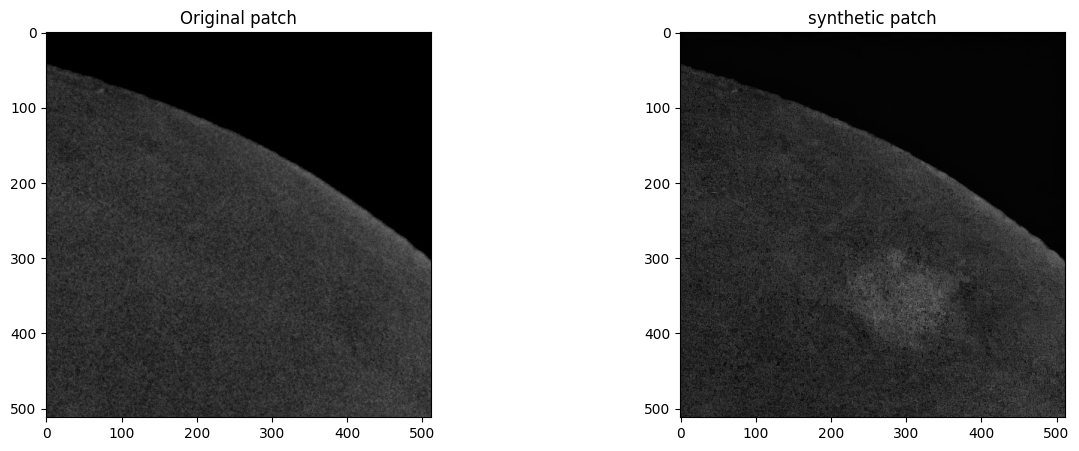

In [4]:
# compare patch gray values and original patch values
original_patch = inpainter.current_image[
    inpainter.current_closeup_coords[1]:inpainter.current_closeup_coords[3],
    inpainter.current_closeup_coords[0]:inpainter.current_closeup_coords[2]
]
channel_num = 0
synthetic_patch = inpainter.current_closup_lesion[:,:,0] 

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(original_patch, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Original patch')
axs[1].imshow(synthetic_patch, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('synthetic patch')
# add histogram
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(original_patch.ravel(), bins=256, range=(0, 255), fc='k', ec='k')
axs[0].set_title('Original patch')
axs[1].hist(synthetic_patch.ravel(), bins=256, range=(0, 255), fc='k', ec='k')
axs[1].set_title('Synthetic patch')

We will compute the difference of the pixel in the patch that:
- are not background 0
- are not in the lesion bo

The mean shift of the pixel values is 7.102028846740723
The std of the pixel values is 13.491642951965332
The median is 7.0


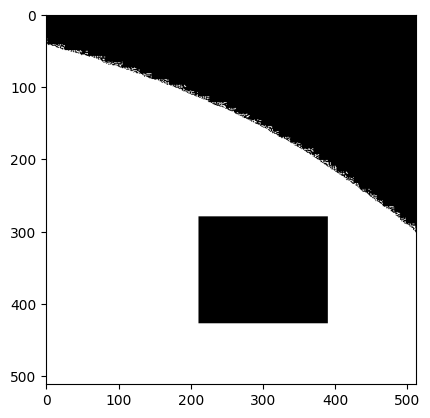

In [39]:
# send to negative all 0 valued pixels
breast_mask = original_patch!=0
lesion_mask = np.zeros_like(original_patch)
# set to 1 all pixels inside the lesion bbox
lesion_mask[inpainter.current_bbox[1]:inpainter.current_bbox[3], inpainter.current_bbox[0]:inpainter.current_bbox[2]] = 1
lesion_mask = lesion_mask!=1
statistical_mask = breast_mask & lesion_mask
# show statistical mask
plt.imshow(statistical_mask, cmap='gray')
# get difference of pixels between the original patch and the synthetic patch using pixels only inside the statistical mask, with isgn
diff = original_patch.astype(np.float32) - synthetic_patch.astype(np.float32)
# extract as one dimentional array only the pixels inside the statistical mask
diff = diff[statistical_mask]
# show boxplot of the difference
plt.figure(figsize=(10,5))
plt.boxplot(diff)
plt.title('Difference between original and synthetic patch')

print(f'The mean shift of the pixel values is {np.mean(diff)}')
print(f'The std of the pixel values is {np.std(diff)}')
print(f'The median is {np.median(diff)}')

Text(0.5, 1.0, 'Synthetic image')

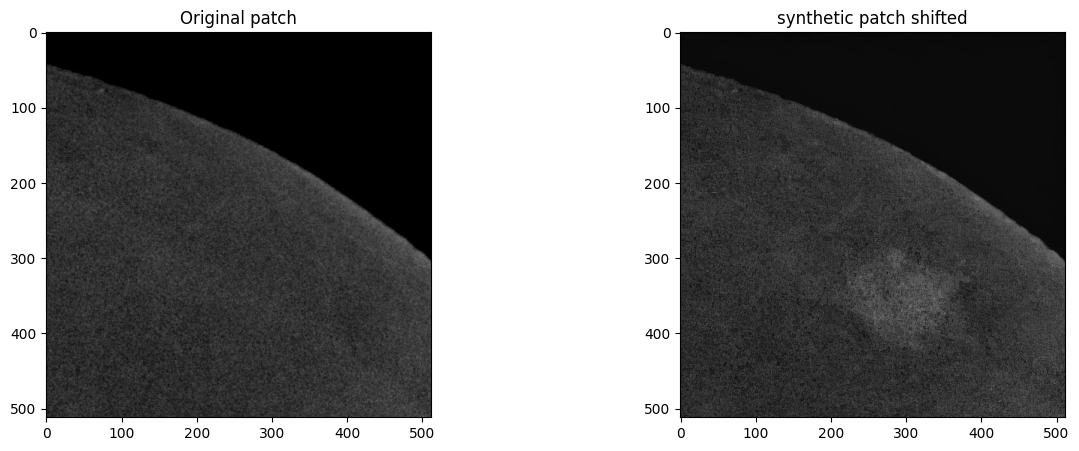

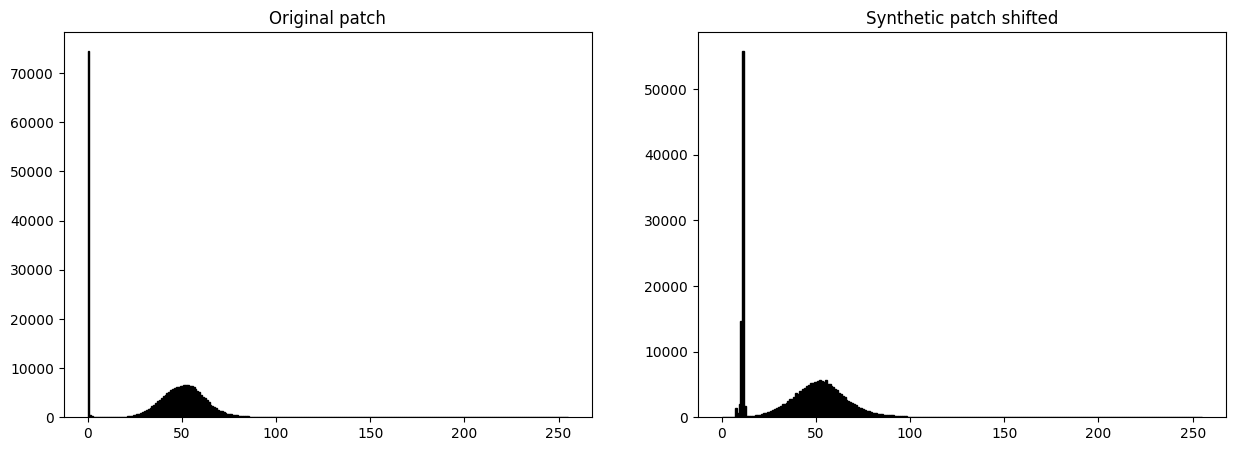

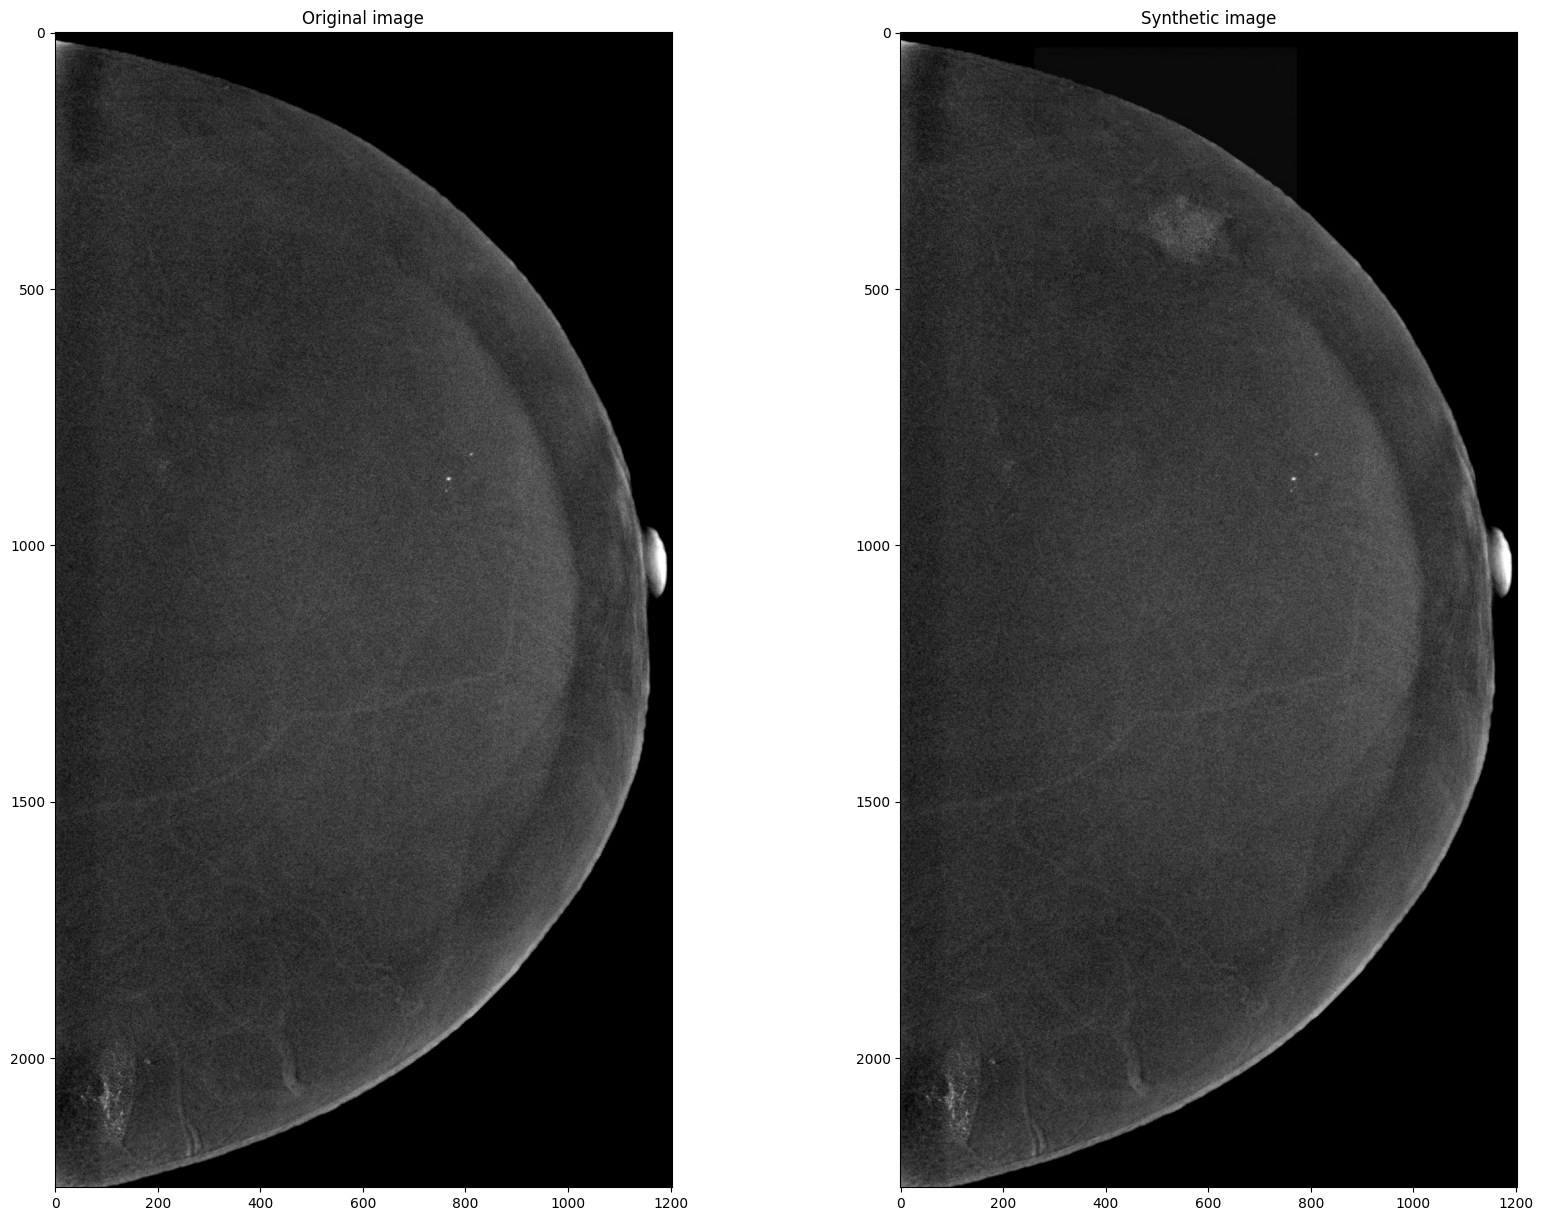

In [42]:
# shift the synthetic patch to match the original patch using the median
synthetic_patch_shifted = synthetic_patch + np.median(diff)
# show the shifted patch next to the original patch
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(original_patch, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Original patch')
axs[1].imshow(synthetic_patch_shifted, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('synthetic patch shifted')
# show histograms of the patches
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(original_patch.ravel(), bins=256, range=(0, 255), fc='k', ec='k')
axs[0].set_title('Original patch')
axs[1].hist(synthetic_patch_shifted.ravel(), bins=256, range=(0, 255), fc='k', ec='k')
axs[1].set_title('Synthetic patch shifted')

new_full_image = inpainter.current_image.copy()
new_full_image[
    inpainter.current_closeup_coords[1]:inpainter.current_closeup_coords[3],
    inpainter.current_closeup_coords[0]:inpainter.current_closeup_coords[2]] = synthetic_patch_shifted # saved as uint8
# show the full image comparison
fig, axs = plt.subplots(1, 2, figsize=(20, 15))
axs[0].imshow(inpainter.current_image, cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(new_full_image, cmap='gray')
axs[1].set_title('Synthetic image')


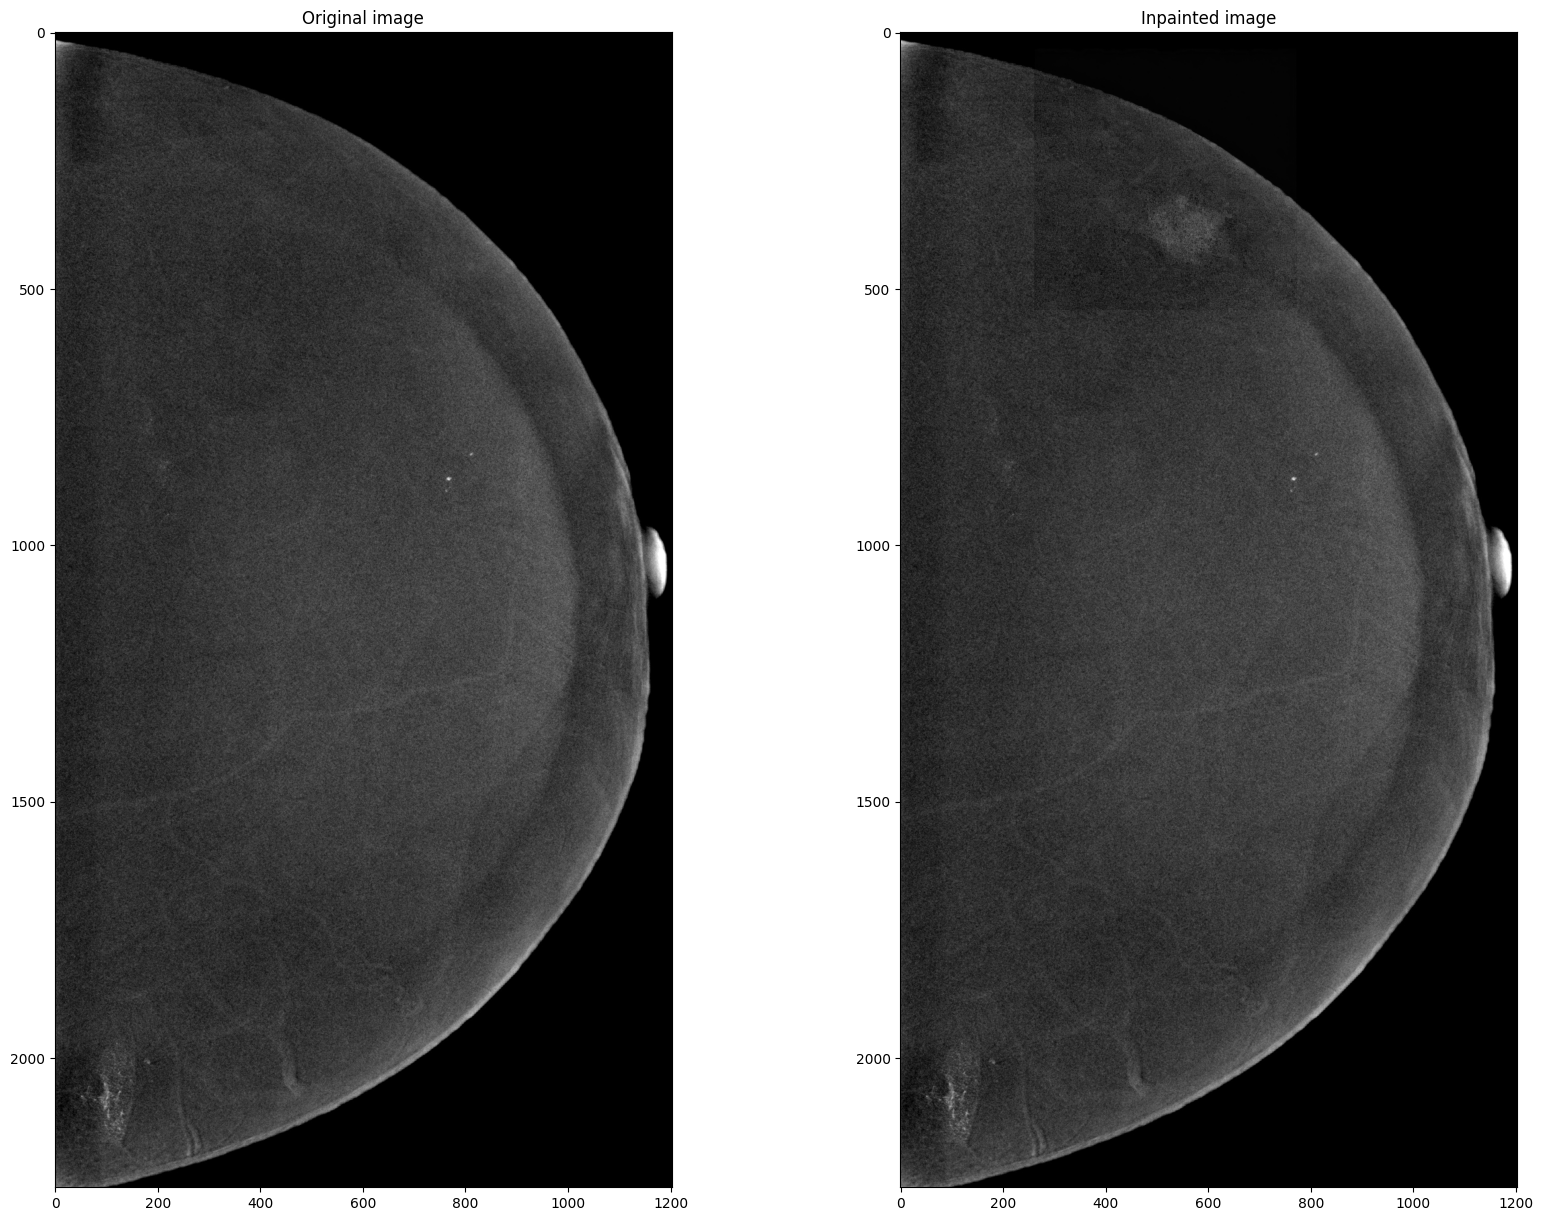

Text(0.5, 1.0, 'Synthetic image')

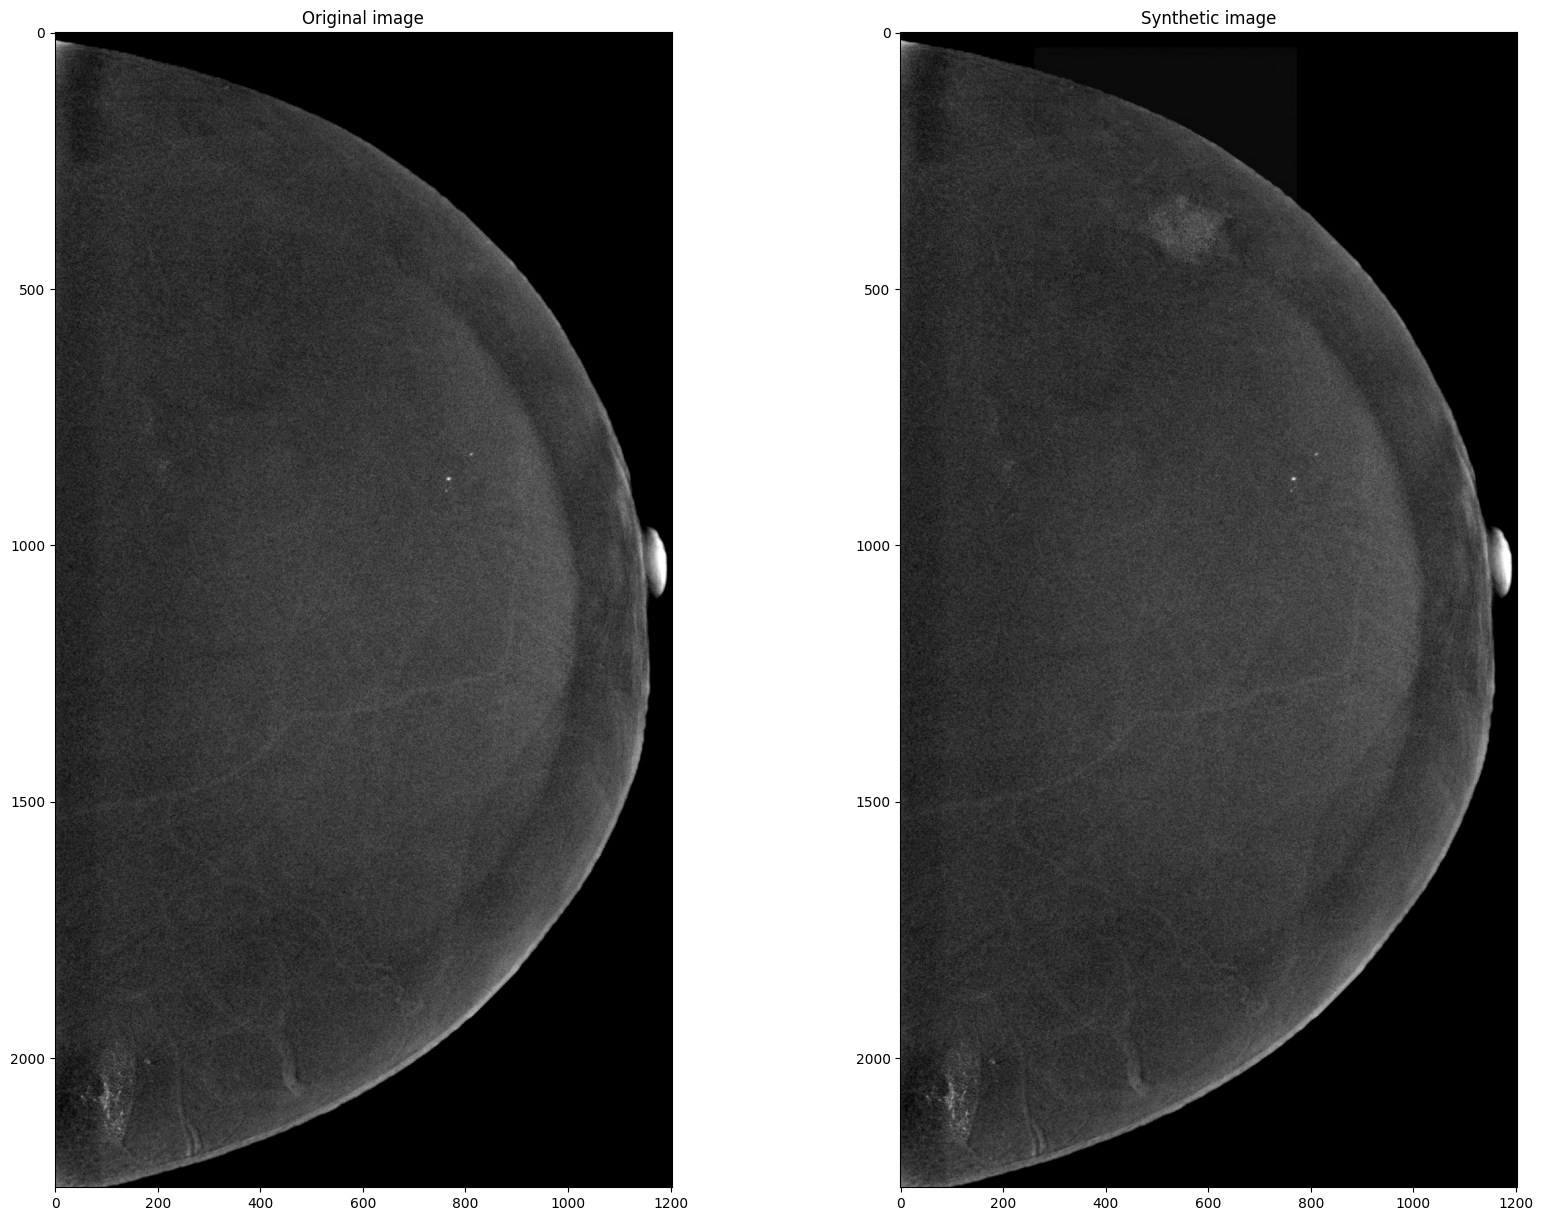

In [47]:
inpainter.show_synthetic_inpainting(figsize=(20, 15), histogram=False)
# summarized pipeline
new_full_image = median_fix(inpainter)
# show the full image comparison
fig, axs = plt.subplots(1, 2, figsize=(20, 15))
axs[0].imshow(inpainter.current_image, cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(new_full_image, cmap='gray')
axs[1].set_title('Synthetic image')

In [48]:
new_full_image.dtype

dtype('uint8')